In [335]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from os import system

family_thresh = 0
family_barcode_num_thresh = 5

def indexing(seq,key,equal):
    ### Find the element in the list that matches a key
    if equal:
        return set([i for i in xrange(len(seq)) if seq[i]==key])
    else:
        return set([i for i in xrange(len(seq)) if seq[i]!=key])

def dist(seq1,seq2):
    ### Calculate the  Levenshtein distance distance of two string, considering 'N' as wildcard
    n1 = indexing(seq1,'N',False)
    n2 = indexing(seq2,'N',False)
    #if max(len(n1),len(n2))>n_thresh:
    #    return 10000
    nindex = list(set.intersection(n1,n2))
    d = 0
    for x in nindex:
        if seq1[x]!=seq2[x]:
            d += 1
    return d

def listdist(seqs1,seqs2,dist_thresh):
    ### If any element of seqs1 matches any element of seq2, we call it a match
    for idx1 in range(len(seqs1)):
        for idx2 in range(len(seqs2)):
            t_dist = dist(seqs1[idx1],seqs2[idx2])
            #print 'dist of ',seqs1[idx1],seqs2[idx2],t_dist
            if t_dist <= dist_thresh:
                return 1
    return 0
    
def family(withbarcode):
    lineage = []
    lineage_mapping = []
    #withbarcode = [[1,1,'abc',2],[1,1,'abN',2]]
    for idx in range(len(withbarcode)):
        t_barcode = withbarcode[idx][2].split(',')
        #print 't_barcode',t_barcode
        found_family = False
        for lineageidx in range(len(lineage)):
            t_lineage = lineage[lineageidx]
            #print 't_lineage',t_lineage

            close2allsample = False
            for sample in t_lineage:
                #print 'sample',sample
                t_dist = listdist(t_barcode,sample,family_thresh)
                if t_dist > 0  and len(t_barcode) + len(sample) - t_dist<family_barcode_num_thresh:
                    close2allsample = True
                    break
            if close2allsample:
                lineage[lineageidx].append(t_barcode)
                found_family = True
                if len(lineage_mapping)<=idx:
                    lineage_mapping.append([lineageidx])
                else:
                    lineage_mapping[idx].append(lineageidx)
                #break
        if not found_family:
            lineage.append([t_barcode]) 
            lineage_mapping.append([len(lineage)-1])
    
    for x in lineage[0]:
        print x
    print '(Recap)Num of valid cell :',len(withbarcode)
    print 'Total num of barcode combo (family):',len(lineage)             
    print 'Num of invalid family with only one cell:', len([1 for x in lineage if len(x)==1]) 
    print 'Num of cells mapped to more than one family:',len([1 for x in lineage_mapping if len(x)>1])
    
    validfamily_cellcnt = [len(x) for x in lineage if len(x)>1]
    validfamily = [idx for idx in range(len(lineage)) if len(lineage[idx])>1]
    print 'Num of valid family (with more than 1 cell):',len(validfamily_cellcnt)
    #print 'Num of valid cells covered by valid family (with more than two cells):',sum(validfamily_cellcnt)
    print 'Num of valid cells covered by valid family (with more than two cells):',sum([1 for x in lineage_mapping if len(set(x).intersection(set(validfamily)))>0])
    
    plt.figure()
    x = pd.Series([np.log10(len(x)) for x in lineage],name="Num (log10) of cell in each family")
    ax = sns.distplot(x);
    pylab.show()
    
    plt.figure()
    x = pd.Series([np.log10(x) for x in validfamily_cellcnt],name="Num (log10) of cell in each VALID family")
    ax = sns.distplot(x);
    pylab.show()
    
    ### Focus only on family with one cell
    onecellfamily = [x for x in lineage if len(x)==1]
    
#     thresh = [0,1,2,3,4,5,100000]
#     percent = []
#     for tidx in range(1,len(thresh)):
#         all = [1 for x in lineage if len(x[0])>thresh[tidx-1] and len(x[0])<=thresh[tidx]]
#         this = [1 for x in onecellfamily if len(x[0])>thresh[tidx-1] and len(x[0])<=thresh[tidx]]
#         percent.append([str(thresh[tidx]) if tidx+1<len(thresh) else '>'+str(thresh[tidx-1]),float(len(this))/len(all) if len(all)>0 else -1])
#     d = pd.DataFrame(percent,columns=['Num of barcode in the family','Percent of the family that has only one cell'])
#     plt.figure()
#     ax = sns.barplot(data=d,x='Num of barcode in the family',y='Percent of the family that has only one cell');
#     pylab.show()

    
def analysis(mappingfile,filtering_metric):
    
    ### Print the Indrop processing stats
    print '#### Printing Indrop preprocessing stats ###'
    with open(filtering_metric) as f:
        for x in f: print x
    print '#### END ###\n'
    
    ### Read the mapping result
    with open(mappingfile) as f:
        data = [x.strip().split() for x in f]

    ### Analysis on the num of reads with PE2 barcode
    print '\n###### Analysis on the num of reads with PE2 barcode'
    print 'Note that we only keep a barcode if it has <66% of 17bp as \'N\''
    withbarcode = [x for x in data if int(x[-1])>0]
    print 'Total num of cell:',len(data)
    print 'Num of cell with any read that has PE2 barcode(valid cell):',len(withbarcode)

    PE2barcode_numthresh = 5
    enoughbarcode = [x for x in withbarcode if int(x[1])>PE2barcode_numthresh]
    print 'Num of valid cell with more than ' + str(PE2barcode_numthresh) + ' reads with PE2 barcode:',len(enoughbarcode)

    plt.figure()
    x = pd.Series([np.log10(int(x[1])) for x in withbarcode], name="num (log10) of reads with PE2 barcode")
    ax = sns.distplot(x);
    pylab.show() 
    
    ### Analysis on the number of unique barcode
    print '\n###### Analysis on the number of unique barcode'
    print '(Recap)Num of valid cell :',len(withbarcode)
    print 'Num of valid cell with 1 unique barcode:',len([x for x in withbarcode if int(x[-1])==1])
    print 'Num of valid cell with 2 unique barcode:',len([x for x in withbarcode if int(x[-1])==2])
    print 'Num of valid cell with more than 2 unique barcode:',len([x for x in withbarcode if int(x[-1])>2])
    plt.figure()
    x = pd.Series([int(x[-1]) for x in withbarcode], name="num of unique PE2 barcode")
    ax = sns.distplot(x);
    pylab.show() 
    
    ### Family analysis
    print '\n###### Analysing family statistics of ALL cell with barcode'
    family(withbarcode)
    
#     print '\n###### Analysing family statistics of only cell with exactly one barcode'
#     print '(Recap)Num of valid cell :',len(withbarcode)
#     withonebarcode = [x for x in data if int(x[-1])==1]
#     print 'Num of cell with exactly one barcode:',len(withonebarcode)
#     family(withonebarcode)
    

In [336]:
# mappingfile = '/cluster/zeng/research/lineage/mESC/post_split/cell-lineage_mapping'
# filtering_metric = '/cluster/zeng/research/lineage/mESC/stats/filtering_metrics.yaml'
# analysis(mappingfile,filtering_metric)

In [337]:
# mappingfile = '/cluster/zeng/research/lineage/endoderm/post_split/cell-lineage_mapping'
# filtering_metric = '/cluster/zeng/research/lineage/endoderm/stats/filtering_metrics.yaml'
# analysis(mappingfile,filtering_metric)

#### Printing Indrop preprocessing stats ###
Rejected Reads: 37401945

Rejection Flags:

  BC1: 5303246

  BC2: 11264389

  No_W1: 12250319

  No_polyT: 2564185

  W1_in_R2: 6019806

Total Reads: 356413993

Valid Fraction: 0.8950603911895233

Valid Reads: 319012048

#### END ###


###### Analysis on the num of reads with PE2 barcode
Note that we only keep a barcode if it has <66% of 17bp as 'N'
Total num of cell: 992
Num of cell with any read that has PE2 barcode(valid cell): 585
Num of valid cell with more than 5 reads with PE2 barcode: 318


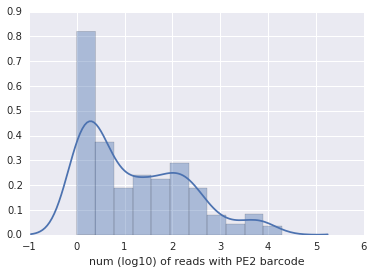


###### Analysis on the number of unique barcode
(Recap)Num of valid cell : 585
Num of valid cell with 1 unique barcode: 311
Num of valid cell with 2 unique barcode: 171
Num of valid cell with more than 2 unique barcode: 103


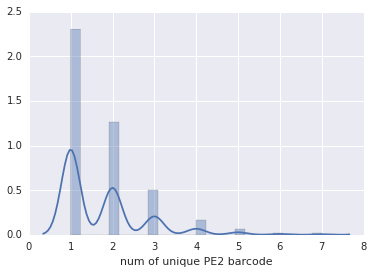


###### Analysing family statistics of ALL cell with barcode
['ATGGCTGTTTATTCTAG', 'ACGAAACTTGNTCGAGG']
['TGGGGCCTGGTACTTGG', 'ACGNNACTTGGTCGAGG']
['ATGGCTGNTTATTCTAG', 'CACTGTTGATAGACTAT']
['GCCTGTCGTGGGNGCGG', 'ACGAAACTTGGTCGAGG', 'GCCTGTCGTGGNGCGGN']
['GGATGCGTTCTTGGCGT', 'ACGAAACTTGGTCGAGG', 'TCATGGAACGGTGGTGT']
['TGGGGCCTGGTACTTGG']
['ACGAAACTTGGTCGAGG']
['GNCACTGNCAGAACCAA', 'CACTGTTGATAGACTAT', 'GTAGGTTTCGACGAATG']
['TGGGGCCTGGTACTTGG']
['TGGGGCCTGGTACTTGG']
['GTGGCGCCCGGGCCGTG', 'GCCTGTCGTGNGNNNNN']
['GCCACTGCCAGAACCAA', 'NNGAGGGCACTTGGGNG']
['TTACCACTGAAACAGAA', 'ATGGCTGTTTATTCTAG']
['TGGGGCCTGGTACTTGG']
['GTACTGGTTGTAGCAGC', 'TGGGGCCTGGTACTTGG']
['TGGGGCCTGGTACTTGG']
['AGGAGGGCACTTGGGAG', 'GGTGGCCTAGCTGGGGC']
['TGGGGCCTGGTACTTGG', 'GACTTTACTTATCATCG', 'TTCCTTCGGGCTTGGAC']
['GGATGCGTTCTTGGCGT']
['ATGGCTGTTTATTCTAG']
['TGGGGCCTGGTACTTGG']
['ACAGAGAAACCCTGTCT', 'AGGAGNGCACNTGGGNG']
['GTATCATAGGTTGGGTC', 'GCCTGTCGTGGGNGCGG']
['GACTTTACTTATCATCG']
['GACTTCCCCAAAGCCAC', 'TTCCTTCGGG

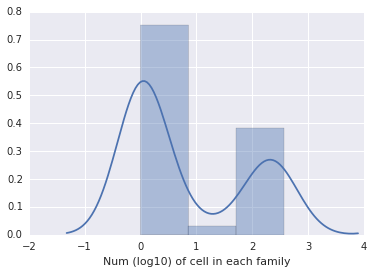

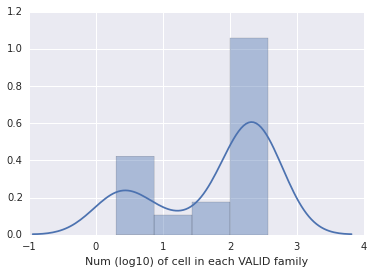

In [338]:
mappingfile = '/cluster/zeng/research/lineage/mESC/post_split/cell-lineage_mapping_quality30_mismatch2'
filtering_metric = '/cluster/zeng/research/lineage/mESC/stats/filtering_metrics.yaml'
analysis(mappingfile,filtering_metric)